<a href="https://colab.research.google.com/github/mrchapagain/ConsumerDataAnalytics/blob/main/Data_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Here i combine Fridata datset with SSI dataset & GPC dataset.**
*   *Frist combine FRIDA dataset with intrested columns*
*   *Second combine GPC dataset with CONCITO dataset with the help of Brickcode/GPC_level4_code*
*   *Then try to extract SSI dataset only the name and match with FRIDA dataset*
*   *Then introduce combined CONCITO_GOPC dataset to the Combined FRIODA_SSI dataset*
*   [Framework](https://github.com/mrchapagain/ConsumerDataAnalytics/raw/main/FoodDataAnalytics%20Dataset%20Framework.jpg)

In [4]:
#@title Necessary libaries { run: "auto", display-mode: "form" }
# Necessary libaries
import pandas as pd
import os

import warnings
warnings.filterwarnings("ignore")

#for user intractivity
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from google.colab import output
#from google.colab import widgets

from google.colab import files

# FRIDA Food Composition Database
***FRIDA Food Composition Database  contain mainly Nutrition value of the each food items***

*   ***Category list:*** https://frida.fooddata.dk/food/lists/grouped?lang=en
*   ***Data display inspiration:*** https://foodb.ca/foods/FOOD00011
*   ***Display on FRIDA:*** https://frida.fooddata.dk/food/754?lang=en

***Import different dataset in FRIDA***

In [2]:
#@title Link for datasets
#path link for dataset
# Import FRIDA Nutrient data
path_frida_data="https://github.com/mrchapagain/ConsumerDataAnalytics/raw/main/FridaNutrientData.xlsx"

# Import FRIDA Group data with Group code
path_frida_data_groups="https://github.com/mrchapagain/ConsumerDataAnalytics/raw/main/FridaNutrientData.xlsx"

# Import FRIDA AdditionalLink data
path_frida_aditional_link="https://github.com/mrchapagain/ConsumerDataAnalytics/raw/main/FridaAdditionalLinkData.xlsx"

***Frida Nutrient dataset***

*   This **`Nutrient dataset`** is the **`*base dataset*`** to have snowballing approach and merge other dataset on the top of it.
*   **`FoodID`** is the unique column in the dataset.

In [3]:
#@title Open FridaNutrient dataset { run: "auto", vertical-output: true }
# Lets open with little modificaton so easy to read and understand
frida_nutrient= pd.read_excel(path_frida_data, sheet_name=1, index_col=None, header=None, skiprows=2).round(decimals = 3).iloc[:, :26]

# Lets define and Assign columns name that defined just above
column_names= ['FoodID', 'FødevareGruppe', 'FødevareNavn', 'Svind_%', 'Energy_kj', 'Energy_kcal', 'Nitrogen_til_protein_faktor', 'Nitrogen_total_g', 'Protein_videnskabelign_g', 'Protein_deklaration_g', 'Kulhydrat_difference_g', 'Kulhydrat_tilgængelig_g', 
               'Kulhydrat_deklaration_g', 'Tilsat_sukker_g', 'Kostfibre_g', 'Fedt_total_g', 'FCF', 'Alkohol_g', 'Aske_g', 'Tørstof_g', 'Vand_g', 'A_vitamin_RE', 'Retinol_µg', 'beta_caroten_µg', 'D_vitamin_µg', 'D3_vitamin_µg']
frida_nutrient.columns= column_names

# lets see frist 3 and last 3 rows od the dataset
frida_nutrient.head(3).append(frida_nutrient.tail(3))

,FoodID,FødevareGruppe,FødevareNavn,Svind_%,Energy_kj,Energy_kcal,Nitrogen_til_protein_faktor,Nitrogen_total_g,Protein_videnskabelign_g,Protein_deklaration_g,...,FCF,Alkohol_g,Aske_g,Tørstof_g,Vand_g,A_vitamin_RE,Retinol_µg,beta_caroten_µg,D_vitamin_µg,D3_vitamin_µg
0,1,Bærfrugt,"Jordbær, rå",4,162,38,6.25,0.106,0.7,0.7,...,0.8,0,0.4,10,90,3.33,0,40,0,0
1,2,Kernefrugt,"Æble, uspec., råt",10,233,55,6.25,0.043,0.3,0.3,...,0.8,0,0.3,15.1,84.9,2.08,0,25,0,0
2,3,Sydfrugt,"Banan, rå",41,396,93,6.25,0.183,1.1,1.1,...,0.73,0,0.7,24.6,75.3,4.42,0,53,0,0
1183,1728,Fedtrig frugt og frø,Chiafrø,iv,1837,447,iv,3.425,21.4,21.4,...,0.887,iv,4.4,93.9,6.1,0,iv,0,0,0
1184,1729,Kornsorter,Perlespelt,iv,1386,329,iv,1.94,12.1,12.1,...,0.598,iv,1.5,88.8,11.2,0,iv,0,0,0
1185,1730,Kornsorter,Perlebyg,iv,1413,335,iv,1.455,9.1,9.1,...,0.548,iv,1.3,89.2,10.8,0,iv,0,0,0


In [4]:
# lets see frist 3 and last 3 rows od the dataset
display_infomatrix=frida_nutrient.info()

#widgets.Dropdown(options=["display_df","display_infomatrix"], description="Select Right Option")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1186 entries, 0 to 1185
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   FoodID                       1186 non-null   int64 
 1   FødevareGruppe               1186 non-null   object
 2   FødevareNavn                 1186 non-null   object
 3   Svind_%                      1186 non-null   object
 4   Energy_kj                    1186 non-null   object
 5   Energy_kcal                  1186 non-null   object
 6   Nitrogen_til_protein_faktor  1186 non-null   object
 7   Nitrogen_total_g             1186 non-null   object
 8   Protein_videnskabelign_g     1186 non-null   object
 9   Protein_deklaration_g        1186 non-null   object
 10  Kulhydrat_difference_g       1186 non-null   object
 11  Kulhydrat_tilgængelig_g      1186 non-null   object
 12  Kulhydrat_deklaration_g      1186 non-null   object
 13  Tilsat_sukker_g              1186

***Frida group dataset***
*   In this dataset, we are interested to extract **`ParantFoodGroupId`** column
*   This dataset can only merge/Join with **`aditional_link dataset`** with column Common **`FoodGroupID`**

In [5]:
# Lets open data as pandas dataframe with adjusted column name
df_frida_groups= pd.read_excel(path_frida_data_groups, sheet_name=3, index_col=None, header=0, skiprows=0)[["FoodGroupID",	"GroupNameDK",	"GroupNameUK", "ParantFoodGroupId"]]

# lets have a look rows with  all the frouts group to have understanding of the rows
df_frida_groups[df_frida_groups.ParantFoodGroupId == 47]

,FoodGroupID,GroupNameDK,GroupNameUK,ParantFoodGroupId
39,48,Anden frugt,Other fruit,47
40,49,Kernefrugt,Pome fruit,47
41,50,Stenfrugt,Stone fruit,47
42,51,Bærfrugt,Soft fruit,47
43,52,Sydfrugt,Tropical or subtropical fruit,47
44,53,Fedtrig frugt og frø,High-fat fruit and seeds,47
45,54,Frugtsaft og juice,Fruit juices,47
46,55,Frugtprodukter,Fruit products,47


In [6]:
df_frida_groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148 entries, 0 to 147
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   FoodGroupID        148 non-null    int64 
 1   GroupNameDK        146 non-null    object
 2   GroupNameUK        146 non-null    object
 3   ParantFoodGroupId  148 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 4.8+ KB


***Frida Aditional_link dataset***
*   This dataset is useful for mainly two columns **`(TaxonomicName	& FoodEx2Code)`**
*   This dataset can first merge with ***Group dataset*** with column **`FoodGroupID`**then after with ***Nutrient dataset***
*   **FoodID** is the unique columns in the dataset

In [7]:
# Lets open with little modificaton so easy to read and understand
df_frida_aditional_link= pd.read_excel(path_frida_aditional_link, sheet_name=3, index_col=None, header=0, skiprows=0)

# lets see first 3 and last 3 rows of the dataset
df_frida_aditional_link.head(3).append(df_frida_aditional_link.tail(3))

,FødevareNavn,FoodName,FoodID,TaxonomicName,FoodEx2Code,FoodGroupID,FødevareGruppe,FoodGroup
0,"Jordbær, rå","Strawberry, raw",1,Fragaria x ananassa Duchesne,A01EA#F02.A067D,51,Bærfrugt,Soft fruit
1,"Æble, uspec., råt","Apple, raw, all varieties",2,Malus domestica Borkh.,A01DJ#F02.A067D$F26.A07XD,49,Kernefrugt,Pome fruit
2,"Banan, rå","Banana, raw",3,Musa x paradisiaca L.,A01LC#F01.A064L$F02.A067D,52,Sydfrugt,Tropical or subtropical fruit
1246,"Stykker, med mycoprotein","Pieces, with mycoprotein",1793,NaN,NaN,169,Plantebaserede produkter,Plant-based products
1247,"Pølse, med sojaprotein","Sausage, with soy protein",1794,NaN,NaN,169,Plantebaserede produkter,Plant-based products
1248,"Oksekød, filet, marmoreret, rå","Beef, entrecote/rib eye, raw",1795,Bos taurus,NaN,58,Oksekød,Beef


In [8]:
df_frida_aditional_link.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1249 entries, 0 to 1248
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   FødevareNavn    1249 non-null   object
 1   FoodName        1249 non-null   object
 2   FoodID          1249 non-null   int64 
 3   TaxonomicName   620 non-null    object
 4   FoodEx2Code     911 non-null    object
 5   FoodGroupID     1249 non-null   int64 
 6   FødevareGruppe  1249 non-null   object
 7   FoodGroup       1249 non-null   object
dtypes: int64(2), object(6)
memory usage: 78.2+ KB


**Combine `food_Group & aditional_link` dataset**

*   From Frida-Group dataset, we only use **` two column and merge`** in the Aditional-Link dataset
*   Common unique column is **FoodGroupID**
After merging unique numbers of FoodGroupID is still same (111) from left dataset, that mean data has not been lost
*   However, we will have 145 nan value in the **ParantFoodGroupId** column of the combined dataset 
*   [Merging options](https://github.com/mrchapagain/ConsumerDataAnalytics/raw/main/join_option.png)



In [9]:
# check the both dataset with "FoodGroupID" column
print("Only exist on Frida AditionalLink dataset:", df_frida_aditional_link[~df_frida_aditional_link['FoodGroupID'].isin(df_frida_groups["FoodGroupID"])].shape)
print("Only exist on Frida-Group dataset:", df_frida_groups[~df_frida_groups['FoodGroupID'].isin(df_frida_aditional_link["FoodGroupID"])].shape)

Only exist on Frida AditionalLink dataset: (145, 8)
Only exist on Frida-Group dataset: (61, 4)


In [10]:
# Now, combine frida group dataset with aditional_link dataset
combinedf_aditionallink_groups= df_frida_aditional_link.merge(df_frida_groups[['FoodGroupID', 'ParantFoodGroupId']], on= 'FoodGroupID', how= 'left')
combinedf_aditionallink_groups.head(3).append(combinedf_aditionallink_groups.tail(3))

,FødevareNavn,FoodName,FoodID,TaxonomicName,FoodEx2Code,FoodGroupID,FødevareGruppe,FoodGroup,ParantFoodGroupId
0,"Jordbær, rå","Strawberry, raw",1,Fragaria x ananassa Duchesne,A01EA#F02.A067D,51,Bærfrugt,Soft fruit,47.0
1,"Æble, uspec., råt","Apple, raw, all varieties",2,Malus domestica Borkh.,A01DJ#F02.A067D$F26.A07XD,49,Kernefrugt,Pome fruit,47.0
2,"Banan, rå","Banana, raw",3,Musa x paradisiaca L.,A01LC#F01.A064L$F02.A067D,52,Sydfrugt,Tropical or subtropical fruit,47.0
1246,"Stykker, med mycoprotein","Pieces, with mycoprotein",1793,NaN,NaN,169,Plantebaserede produkter,Plant-based products,NaN
1247,"Pølse, med sojaprotein","Sausage, with soy protein",1794,NaN,NaN,169,Plantebaserede produkter,Plant-based products,NaN
1248,"Oksekød, filet, marmoreret, rå","Beef, entrecote/rib eye, raw",1795,Bos taurus,NaN,58,Oksekød,Beef,56.0


In [11]:
combinedf_aditionallink_groups.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1249 entries, 0 to 1248
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   FødevareNavn       1249 non-null   object 
 1   FoodName           1249 non-null   object 
 2   FoodID             1249 non-null   int64  
 3   TaxonomicName      620 non-null    object 
 4   FoodEx2Code        911 non-null    object 
 5   FoodGroupID        1249 non-null   int64  
 6   FødevareGruppe     1249 non-null   object 
 7   FoodGroup          1249 non-null   object 
 8   ParantFoodGroupId  1104 non-null   float64
dtypes: float64(1), int64(2), object(6)
memory usage: 97.6+ KB


***Compare `frida-Nutrient` and `combineddf-aditionallink-group` dataset to understand merging options***

In [12]:
#@title Compare frida-Nutrient and combineddf-aditionallink-group dataset to understand merging options
# Compare Nutrient vs Frida-aditional_link dataset and find the rows that are not exist in eachother 

# with "FødevareNavn" column
print("Compare with 'FødevareNavn' column")
print("Only exist on Frida Nutrient dataset:", frida_nutrient[~frida_nutrient['FødevareNavn'].isin(combinedf_aditionallink_groups["FødevareNavn"])].shape)
print("Only exist on Frida-combine-aditionallink-group:", combinedf_aditionallink_groups[~combinedf_aditionallink_groups['FødevareNavn'].isin(frida_nutrient["FødevareNavn"])].shape)
print()

# with "FødevareGruppe" column
print("Compare with 'FødevareGruppe' column")
print("Only exist in Nitrient dataset:", frida_nutrient[~frida_nutrient['FødevareGruppe'].isin(combinedf_aditionallink_groups["FødevareGruppe"])].shape)
print("Only exist in Frida-combine-aditionallink-group:", combinedf_aditionallink_groups[~combinedf_aditionallink_groups['FødevareGruppe'].isin(frida_nutrient["FødevareGruppe"])].shape)
print()

# with "FoodID "column
print("Compare with 'FoodID' column")
print("Only exist in Nitrient dataset:", frida_nutrient[~frida_nutrient['FoodID'].isin(combinedf_aditionallink_groups["FoodID"])].shape)
print("Only exist in Frida-combine-aditionallink-group:", combinedf_aditionallink_groups[~combinedf_aditionallink_groups['FoodID'].isin(frida_nutrient["FoodID"])].shape)

Compare with 'FødevareNavn' column
Only exist on Frida Nutrient dataset: (45, 26)
Only exist on Frida-combine-aditionallink-group: (108, 9)

Compare with 'FødevareGruppe' column
Only exist in Nitrient dataset: (442, 26)
Only exist in Frida-combine-aditionallink-group: (477, 9)

Compare with 'FoodID' column
Only exist in Nitrient dataset: (4, 26)
Only exist in Frida-combine-aditionallink-group: (67, 9)


***Sumarry of two dataset from FRIDA: `Frida_Nutrient` and `combinedf_aditionallink_group`***

When comparing columns in two dataset of ***Frida_Nutrient*** and ***combinedf_aditionallink_groups***, the matching column ***FoodID*** gives the maximun matching rows so i used FoodID as a merging column
*   ***4 rows*** in `data_frida['FoodID']` are not in `data_frida_aditional_link["FoodID"]`, which mean we only got 4 nan values from right table. 
*   on the otherhand, ***67 rows*** in `combinedf_aditionallink_groups["FoodID"]` are not in `data_frida['FoodID']` 
*   So, i consider ***data_frida as a base dataset*** and only merge the rows that exist in data_frida. Which can be done with ***left join***.
*   `'FødevareNavn' and 'FødevareGruppe'` columns are also common in both dataset so we do exclude them from right table during merging and include only `'FoodName', 'FoodID', 'TaxonomicName', 'FoodEx2Code', 'FoodGroupID', 'FoodGroup', 'ParantFoodGroupId'`.


In [13]:
# Frida combined-Additionallink-group dataset & Nutrient Dataset
finaldf_fridanutrient_aditionallink_groups= frida_nutrient.merge(combinedf_aditionallink_groups[['FoodName', 'FoodID', 'TaxonomicName', 'FoodEx2Code', 'FoodGroupID', 'FoodGroup', 'ParantFoodGroupId']], on= 'FoodID', how= 'left')
finaldf_fridanutrient_aditionallink_groups.head(3).append(finaldf_fridanutrient_aditionallink_groups.tail(3))

,FoodID,FødevareGruppe,FødevareNavn,Svind_%,Energy_kj,Energy_kcal,Nitrogen_til_protein_faktor,Nitrogen_total_g,Protein_videnskabelign_g,Protein_deklaration_g,...,Retinol_µg,beta_caroten_µg,D_vitamin_µg,D3_vitamin_µg,FoodName,TaxonomicName,FoodEx2Code,FoodGroupID,FoodGroup,ParantFoodGroupId
0,1,Bærfrugt,"Jordbær, rå",4,162,38,6.25,0.106,0.7,0.7,...,0,40,0,0,"Strawberry, raw",Fragaria x ananassa Duchesne,A01EA#F02.A067D,51.0,Soft fruit,47.0
1,2,Kernefrugt,"Æble, uspec., råt",10,233,55,6.25,0.043,0.3,0.3,...,0,25,0,0,"Apple, raw, all varieties",Malus domestica Borkh.,A01DJ#F02.A067D$F26.A07XD,49.0,Pome fruit,47.0
2,3,Sydfrugt,"Banan, rå",41,396,93,6.25,0.183,1.1,1.1,...,0,53,0,0,"Banana, raw",Musa x paradisiaca L.,A01LC#F01.A064L$F02.A067D,52.0,Tropical or subtropical fruit,47.0
1183,1728,Fedtrig frugt og frø,Chiafrø,iv,1837,447,iv,3.425,21.4,21.4,...,iv,0,0,0,Chia seeds,Salvia hispanica,A16FZ,177.0,High-fat seeds,NaN
1184,1729,Kornsorter,Perlespelt,iv,1386,329,iv,1.94,12.1,12.1,...,iv,0,0,0,Pearled spelt,Triticum spelta,A001R,28.0,Grain and groats,26.0
1185,1730,Kornsorter,Perlebyg,iv,1413,335,iv,1.455,9.1,9.1,...,iv,0,0,0,Pearled barley,Hordeum vulgare,A002K,28.0,Grain and groats,26.0


In [14]:
# Lets compare the "FødevareNavn" column of database before merge and after merge 
finaldf_fridanutrient_aditionallink_groups[["FoodID",	"FødevareGruppe",	"FødevareNavn"]].compare(frida_nutrient[["FoodID",	"FødevareGruppe",	"FødevareNavn"]])

Empty DataFrame
Columns: []
Index: []

In [15]:
finaldf_fridanutrient_aditionallink_groups.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1186 entries, 0 to 1185
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   FoodID                       1186 non-null   int64  
 1   FødevareGruppe               1186 non-null   object 
 2   FødevareNavn                 1186 non-null   object 
 3   Svind_%                      1186 non-null   object 
 4   Energy_kj                    1186 non-null   object 
 5   Energy_kcal                  1186 non-null   object 
 6   Nitrogen_til_protein_faktor  1186 non-null   object 
 7   Nitrogen_total_g             1186 non-null   object 
 8   Protein_videnskabelign_g     1186 non-null   object 
 9   Protein_deklaration_g        1186 non-null   object 
 10  Kulhydrat_difference_g       1186 non-null   object 
 11  Kulhydrat_tilgængelig_g      1186 non-null   object 
 12  Kulhydrat_deklaration_g      1186 non-null   object 
 13  Tilsat_sukker_g   

**Summary of final dataset from FRIDA**

*   Complete dataset with Nutrient-data as a base dataset
*   Posibility to explore ***TaxonomicName & FoodEx2Code*** columns

#CONCITO-Climate and GS1-GPC dataset

***Import dataset: CONCITO Climate dataset and GS1 GPC dataset***


In [16]:
#@title Data sources
# Climate dataset
path_climate_data="https://github.com/mrchapagain/ConsumerDataAnalytics/raw/main/ClimateData.xlsx"

#TradeSync GPC dataset
path_tradesync_excel= "https://github.com/mrchapagain/ConsumerDataAnalytics/raw/main/GS1_GPC_Dataset.xlsx" 

***CONCITO climate dataset***

*   CONCITO Climate dataset and GS1 GPC dataset have a kind of similar format in datapoints. They both are organized in the concept of **`Brick_Code`**.
*   From this dataset, we are mainly interested on CO2 footprint, with columns: **`"Agriculture", "iLUC", "Processing", "Packaging", "Transport", "Retail", "Total_CO2_eq_perkg", "Data_Source", "Comments"`**
*  Matching column will be **`GPC_Level4_dk`**. However this column should change to integer (int) type as matching column in other dataset is integer type.
*  Although there are **500 rows** but only have **205** unique **GPC_Level4_dk** (Brick-Code)

In [17]:
#@title Open CONCITO dataset
from numpy.core import numeric
# Loading CONCITO climate dataset into the data-frame
col_names= ["id", "Product_dk", "Category_dk", "Product_en", "Category_en", "Unit", "Agriculture", "iLUC", "Processing", "Packaging", "Transport", "Retail", "Total_CO2_eq_perkg", "Energy_KJ", "Fat_g", "Carb_g", "Protein_g", "Data_Source", "Comments", "GPC_Level4_en", "ID_Food", "ID_Pack", "ID_Retail", "GPC_Category_en", "GPC_Category_dk", "GPC_Level4_dk", "product_type", "GPC_level1", "Food_group", "GPC_level2", "Un/Processed", "GPC_Level3", "Extra_category"]
cols_to_use= ['Product_dk',	"Product_en", 'Category_dk', "Category_en", "GPC_Level4_dk", "Fat_g", "Carb_g", "Protein_g", "Energy_KJ", "Agriculture", "iLUC", "Processing", "Packaging", "Transport", "Retail", "Total_CO2_eq_perkg", "Data_Source", "Comments"]

# Original columns name are replaced with ralavant names (col_names) and open only selected columns
df_climate_selected= pd.read_excel(path_climate_data, sheet_name=1, index_col=False, header=None, skiprows=1, names= col_names).loc[:, cols_to_use].round(decimals = 2)

# Some of the numeric columns are string format so need to adjust datatypes of the some of the columns
df_climate_selected["GPC_Level4_dk"]= pd.to_numeric(df_climate_selected["GPC_Level4_dk"], errors = 'coerce')
df_climate_selected["Carb_g"]= pd.to_numeric(df_climate_selected["Carb_g"], errors = 'coerce')
df_climate_selected["Protein_g"]= pd.to_numeric(df_climate_selected["Protein_g"], errors = 'coerce')

# replace relavant value to the nan value of the Carb_g and Protein_g columns
df_climate_selected["Carb_g"].iloc[49:50]= 3.5
df_climate_selected['Protein_g'].iloc[49:50]= 13.0

# one row with the water have nan value to brick code so its wiser to drop this row as water do not have much intresting information
#"Beef, fillet, defatted, raw" row have very high difference with other row. so during the EDA process this row is counted as outlier. to have better overview and analytics, this row should be dropped.
to_drop1= df_climate_selected[df_climate_selected["Product_en"] == "Water, tap, drinking, average values"].index
to_drop2= df_climate_selected[df_climate_selected["Product_en"] == "Beef, fillet, defatted, raw"].index
to_drop= [to_drop1[0], to_drop2[0]]
df_climate_selected= df_climate_selected.drop(labels=to_drop, inplace=False).reset_index(drop=True)

# lets have a look some of the data points
df_climate_selected.head(3).append(df_climate_selected.tail(3))

,Product_dk,Product_en,Category_dk,Category_en,GPC_Level4_dk,Fat_g,Carb_g,Protein_g,Energy_KJ,Agriculture,iLUC,Processing,Packaging,Transport,Retail,Total_CO2_eq_perkg,Data_Source,Comments
0,"Peberfrugt, rød, rå","Pepper, sweet, red, raw",Grøntsager,Vegetables,10006191.0,0.1,5.2,0.9,133.0,0.25,0.03,0.00,0.14,0.58,0.01,1.02,The inputs to the Danish market and inputs and...,Data are obtained as products on the Danish cr...
1,"Tomat, uspec., rå","Tomato, ripe, raw, origin unknown",Grøntsager,Vegetables,10006165.0,0.1,3.2,0.8,87.0,0.07,0.01,0.00,0.14,0.48,0.01,0.70,The inputs to the Danish market and inputs and...,Data are obtained as products on the Danish cr...
2,"Squash, rå","Squash, raw",Grøntsager,Vegetables,10006355.0,0.2,2.4,1.4,81.0,0.14,0.04,0.00,0.06,0.58,0.01,0.83,The inputs to the Danish market and inputs and...,Data are obtained as products on the Danish cr...
495,Pålægschokolade,Cold chocolate,Slik/sukkervarer,Candy/sugar products,10000045.0,40.0,44.0,8.9,2403.0,1.83,0.34,2.52,0.38,0.11,0.01,5.18,Data on inputs and outputs of the food process...,It has been assumed that the food processing i...
496,"Nutella, nøddecreme","Nutella, nut cream",Slik/sukkervarer,Candy/sugar products,10000045.0,31.6,57.6,6.0,2278.0,1.68,0.44,1.32,0.42,0.10,0.01,3.97,Data on inputs and outputs of the food process...,It has been assumed that the food processing i...
497,"Smoothie, jordbær blåbær","Smoothie, strawberry blueberry",Drikkevarer,Beverages,10000219.0,0.0,9.5,0.4,183.0,0.40,0.07,0.10,0.31,1.29,0.00,2.16,Data on inputs and outputs of the food process...,It has been assumed that the food processing i...


In [18]:
df_climate_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498 entries, 0 to 497
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Product_dk          498 non-null    object 
 1   Product_en          498 non-null    object 
 2   Category_dk         498 non-null    object 
 3   Category_en         498 non-null    object 
 4   GPC_Level4_dk       498 non-null    float64
 5   Fat_g               498 non-null    float64
 6   Carb_g              498 non-null    float64
 7   Protein_g           498 non-null    float64
 8   Energy_KJ           498 non-null    float64
 9   Agriculture         498 non-null    float64
 10  iLUC                498 non-null    float64
 11  Processing          498 non-null    float64
 12  Packaging           498 non-null    float64
 13  Transport           498 non-null    float64
 14  Retail              498 non-null    float64
 15  Total_CO2_eq_perkg  498 non-null    float64
 16  Data_Sou

In [32]:
# Download final clean dataset so far
climate= df_climate_selected
frida_final= finaldf_fridanutrient_aditionallink_groups

climate= finaldf_fridanutrient_aditionallink_groups.to_excel('finaldf_fridanutrient_aditionallink_groups.xlsx', encoding = 'UTF-8') 
files.download('finaldf_fridanutrient_aditionallink_groups.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#**GS1 TradeSync GPC**

***GS1 TradeSync GPC: `df_tradesync_gpc` dataset***

---

*   This dataset mainly organize around **`Brick_code`**, very foundation of product identity.
*   **`GTIN`** (EAN/UPC) can link to unique Brick-Code. With the Brock-code, the item can be devided to different **`Attribute and coresponded value`**. On the other hand the item can be groupped to Class, Family and Segment.
*   In this dataset, we are mainly interested to columns; 
> *  ***`BrickCode`***, to identify product **(total 5194)** and connect with climate dataset 
> *  ***`Attribute and their Values`*** to further breakdown the Brick_Code
> *  ***`Segment_code, Family_code & Class_codes`***, to categorize the item 

*   [GTIN: BrickCode](https://github.com/mrchapagain/ConsumerDataAnalytics/raw/main/Copy%20of%20Dipendra%20dai%20NRNA%202017%20(1).jpg)

In [20]:
#@title Open GS1 GPC dataste { display-mode: "both" }
# Selective columns names
columns = ['SegmentCode', 'SegmentTitle', 'FamilyCode', 'FamilyTitle', 'ClassCode', 'ClassTitle', 'BrickCode', 'BrickTitle', 'AttributeCode', 'AttributeTitle', 'AttributeValueCode', 'AttributeValueTitle']

# Lets open data as they are
df_tradesync_excel= pd.read_excel(path_tradesync_excel, sheet_name=0, index_col=None, header=0, skiprows=0)
df_tradesync_excel.head(2).append(df_tradesync_excel.tail(2))

# Open the dataset with selective columns names
df_tradesync_gpc = df_tradesync_excel[columns]
df_tradesync_gpc.head(3).append(df_tradesync_gpc.tail(3))

,SegmentCode,SegmentTitle,FamilyCode,FamilyTitle,ClassCode,ClassTitle,BrickCode,BrickTitle,AttributeCode,AttributeTitle,AttributeValueCode,AttributeValueTitle
0,70000000,Arts/Crafts/Needlework,70010000,Arts/Crafts/Needlework Supplies,70010200,Airbrushing Supplies,10001686,Airbrushes (Powered),NaN,NaN,NaN,NaN
1,70000000,Arts/Crafts/Needlework,70010000,Arts/Crafts/Needlework Supplies,70010200,Airbrushing Supplies,10001688,Airbrushing Equipment - Replacement Parts/Acce...,20001349.0,Type of Airbrushing Equipment - Replacement Pa...,30008542.0,AIRBRUSH CONTROL VALVE
2,70000000,Arts/Crafts/Needlework,70010000,Arts/Crafts/Needlework Supplies,70010200,Airbrushing Supplies,10001688,Airbrushing Equipment - Replacement Parts/Acce...,20001349.0,Type of Airbrushing Equipment - Replacement Pa...,30008543.0,AIRBRUSH HOSE
183205,77000000,Vehicle,77030000,Cars and Motorcycles,77030200,Motorcycles/ All Terrain Vehicles/ Utility Tas...,10006773,Utility Task Vehicles (UTVs)/ Recreational Off...,20002877.0,Type of Energy,30002515.0,UNCLASSIFIED
183206,77000000,Vehicle,77030000,Cars and Motorcycles,77030200,Motorcycles/ All Terrain Vehicles/ Utility Tas...,10006773,Utility Task Vehicles (UTVs)/ Recreational Off...,20002877.0,Type of Energy,30002518.0,UNIDENTIFIED
183207,77000000,Vehicle,77050000,Specialty Vehicles,77050100,Specialty Vehicles,10008050,Specialty Vehicles,NaN,NaN,NaN,NaN


In [21]:
#data_tradesync_excel.info()
df_tradesync_gpc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183208 entries, 0 to 183207
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   SegmentCode          183208 non-null  int64  
 1   SegmentTitle         183208 non-null  object 
 2   FamilyCode           183208 non-null  int64  
 3   FamilyTitle          183208 non-null  object 
 4   ClassCode            183208 non-null  int64  
 5   ClassTitle           183208 non-null  object 
 6   BrickCode            183208 non-null  int64  
 7   BrickTitle           183208 non-null  object 
 8   AttributeCode        181646 non-null  float64
 9   AttributeTitle       181646 non-null  object 
 10  AttributeValueCode   181646 non-null  float64
 11  AttributeValueTitle  181646 non-null  object 
dtypes: float64(2), int64(4), object(6)
memory usage: 16.8+ MB


In [22]:
# Length of the unique Brick-Code
len(df_tradesync_gpc.BrickCode.unique())

5194

***Posibility of combining CONCITO_Climate & GS1_GPC_Tradesync datasets***

---
*   these two dataset have one column in common Brick-Code **`Brick-code`** in GPC dataste and ***GPC_Level4_dk*** in Concito-Climate dataset
*   due to the there only 205 unique brick-code in concito dataset and connecting GPC dataset do not add any aditional value to the dataset so it has not relavancy to connect these two dataste

In [3]:
# CONCITO dataset with GS1-GPC dataset
combinedf_gpc_climate= df_tradesync_gpc.merge(df_climate_selected[["GPC_Level4_dk", "Agriculture", "iLUC", "Processing", "Packaging", "Transport", "Retail", "Total_CO2_eq_perkg", "Data_Source", "Comments"]], left_on= 'BrickCode', right_on= 'GPC_Level4_dk', how= 'left')
combinedf_gpc_climate.head(2).append(combinedf_gpc_climate.tail(2))

#@title Checking the BrickCode "10000045" in different dataset { run: "auto", vertical-output: true }
Dataset = Climate #@param ["TradeSync", "Climate", "Combine"] {type:"raw"}

# Checking the BrickCode columns in different dataset
TradeSync= df_tradesync_gpc[df_tradesync_gpc.BrickCode== 10000045.0]
Climate= df_climate_selected[df_climate_selected.GPC_Level4_dk== 10000045.0]
Combine= combinedf_gpc_climate[combinedf_gpc_climate.BrickCode== 10000045.0]
Dataset

NameError: ignored

In [ ]:
combinedf_gpc_climate.info()

***Exploring connecting column and feacture for FRIDA and GPC_Concito dataset***

# Data by Frederik

***Columns description***

*   **itemname:** name provided by the merchant. It often, but not always, contains a enough information to ID the product.  Sometimes weight, or other information is also provided here.
*   **itemnumber:** the product itemnumber. It can be a standardized GTIN 13 number ( 12-13 digits) supported by GS1 or a non standard number created by the retailer to identify i.e. Bananas
*   **category:** a category code not sure how to interpret and often missing
*   **percent_purchases:** Percent off all receipt lines in the dataset where each line is a purchas

In [ ]:
# Import data
path_ssi_data="https://github.com/mrchapagain/ConsumerDataAnalytics/raw/main/cpd_summary.csv"

# Open data as csv file
data_ssi= pd.read_csv(path_ssi_data, sep= ";", index_col=False, encoding='latin-1')

# itemnumber culumn is string although it is integer, lets turn it to integer
#But there are NULL value so can not converted to integer type
#data_ssi["itemnumber"]= data_ssi["itemnumber"].astype(int)

# lets see frist 3 and last 3 rows od the dataset
display_as_dataframe= data_ssi.head(3).append(data_ssi.tail(5))

#data_ssi.at[14,'brick_code']=0
display_only_banana_rows= data_ssi.iloc[[11, 12, 14, 18], :] 

#@title Open SSi dataset (data_ssi) { run: "auto", vertical-output: true, display-mode: "code" }
Display_Option = display_as_dataframe #@param ["display_as_dataframe", "display_only_banana_rows"] {type:"raw"}
Display_Option

In [ ]:
# Download cleaned dataset
#data_ssi.to_excel('data_ssi.xlsx', encoding = 'utf-8-sig') 
#files.download('data_ssi.xlsx')

# TradeSync GTIN Link data from GS1 

In [ ]:
#@title Open file and explore the number of files { run: "auto", vertical-output: true }
import glob
import xml.etree.ElementTree as ET

#Import gs1 xmll files
path_tradesync_data= "/content/drive/MyDrive/Data_gs1_xml/"
xmls = glob.glob(path_tradesync_data + '*.xml')
print("Toal amount of TradeSync_xml files: ", len(xmls))

In [ ]:
#@title See what we can get out from one XML file of TradeSync_XML file { run: "auto", vertical-output: true }
# Funccction to extract data from xml files
def gs1_xml_reader(file):
  """This function will take xml file and return GTIN and Brick code as key:value pair including other relavant feactures"""
  tree = ET.parse(file)
  root = tree.getroot()
  keys_of_items_to_find= ("gtin", "gpcCategoryCode", "brandName", 'functionalName', 'descriptionShort', "additionalTradeItemIdentification", "uniformResourceIdentifier", "ingredientStatement")
  
  #Lets start the dictionary to collecct items 
  dit= dict([(key,[]) for key in keys_of_items_to_find])

  # Loop over the tags that make sense (from list above)
  for list_item in keys_of_items_to_find:
    # Again  looping to get the text value
    for item in root.iter(list_item):
      if item.text not in dit[list_item]:
        if list_item == "gtin":
          dit[list_item].append(item.text[1:])
        else:
          dit[list_item].append(item.text)
      #else:
        #dit[list_item].append(0)
  # The data are Dictionary of lists so lets print them to see
  return dit

display(gs1_xml_reader(xmls[0]))

# Check the data type
print("*" * 40)
print("Data tyepe of ", type(gs1_xml_reader(xmls[0])))


***The above data are in a form of dictionary. Dictionary of list.***

In [ ]:
# Lets loop over all the files and extract the GTIN code and associated Brick-codes
keys_of_items_to_find= ("gtin", "gpcCategoryCode", "brandName", 'functionalName', 'descriptionShort', "additionalTradeItemIdentification", "uniformResourceIdentifier", "ingredientStatement")
dit= dict([(key,[0]) for key in keys_of_items_to_find])
df_with_gtin_list = pd.DataFrame()
for xml in xmls[:]:
  df_with_gtin_list= df_with_gtin_list.append(gs1_xml_reader(xml), ignore_index = True)
  
#Define display variables
Whole_dataframe= df_with_gtin_list
only_GTIN_BrickCode_dataframe= df_with_gtin_list[["gtin",	"gpcCategoryCode"]]

#@title Extract all xml files and turn them to dataframe (df_with_gtin_list) { run: "auto", vertical-output: true }
Display_Option = only_GTIN_BrickCode_dataframe #@param ["Whole_dataframe", "only_GTIN_BrickCode_dataframe"] {type:"raw"}
Display_Option

In [ ]:
#@title explore the SSI dataset with GTIN code from GS1 (but disablenow) { run: "auto", vertical-output: true }
"""# lets explore the SSI dataset with GTIN code from GS1

#iterate over gtin and Brick-code dataset
data_ssi["brick_code"] =""
for row, col in gtin_brickcode.iterrows():
  gtin_list= col.gtin #["5712873336944", '	5711044628659', '5707402006641', '406', '5711044628659', '5707402008119', '5707402008171', '0000057014388']
  gpc_code= col.gpcCategoryCode[0]
  #print("gtin:", gtin_list)
  #print("brik:", gpc_code)
  #print("-"*40)

  # now lets take a row from SSI dataset
  for  row, col in data_ssi.iloc[:,:].iterrows():    
    # check if itemnumber from SSI rows is exist in the column of GTIN code list
    if col.itemnumber in gtin_list:
      data_ssi.at[row,'brick_code']=gpc_code
      print(data_ssi.brick_code.unique())
    else:
      pass
  #print("*"* 40)"""
  

In [ ]:
from google.colab import files
df_with_gtin_list= df_with_gtin_list[["gtin", "gpcCategoryCode", "brandName", 'functionalName', 'descriptionShort', 'additionalTradeItemIdentification', "uniformResourceIdentifier","ingredientStatement"]].iloc[:,:]
df_with_gtin_list.to_excel('df_with_gtin_list.xlsx', encoding = 'utf-8-sig') 
#files.download('df_with_gtin_list.xlsx')

In [ ]:
#@title API for EAN
!pip3 install eansearch
from eansearch import EANSearch

ean_list= ['05701018044677', '05000387905634', 25109, 5712873336944, 5712580050171, 20008932, 20014018, 20023393, 5712580000114, "05766632526800"]
ean = ean_list[0]
apiToken = "a09851e102099d04448394e0b838bc345c8fd98a"


"""eansearch = EANSearch(apiToken)
eanList = eansearch.productSearch('Bananas')
for product in eanList:
	print(product["ean"], " is ", product["name"].encode("utf-8"))"""
 
lookup = EANSearch(apiToken)
name = lookup.barcodeLookup(ean)
print(ean, " is ", name)

# Now lets try to work with cleaned final combined dataset
data_frida_final= "https://github.com/mrchapagain/ConsumerDataAnalytics/raw/main/finaldf_fridanutrient_aditionallink_groups.xlsx"

data_climate_selected= "https://github.com/mrchapagain/ConsumerDataAnalytics/raw/main/df_climate_selected.xlsx"

data_ssi="https://github.com/mrchapagain/ConsumerDataAnalytics/raw/main/cpd_summary.csv"

In [4]:
#@title Display dataframe { run: "auto", vertical-output: true }
data_frida_final= "https://github.com/mrchapagain/ConsumerDataAnalytics/raw/main/finaldf_fridanutrient_aditionallink_groups.xlsx"
data_climate_selected= "https://github.com/mrchapagain/ConsumerDataAnalytics/raw/main/df_climate_selected.xlsx"
data_ssi="https://github.com/mrchapagain/ConsumerDataAnalytics/raw/main/cpd_summary.csv"

Display_options = data_frida_final #@param ["data_frida_final", "data_climate_selected", "data_ssi"] {type:"raw"}

DataFrame= pd.read_excel(Display_options, sheet_name=0, index_col=0, header=0, skiprows=0)
#pd.read_csv(Display_options, sep= ";", index_col=False, encoding='latin-1')
DataFrame


,FoodID,FødevareGruppe,FødevareNavn,Svind_%,Energy_kj,Energy_kcal,Nitrogen_til_protein_faktor,Nitrogen_total_g,Protein_videnskabelign_g,Protein_deklaration_g,...,Retinol_µg,beta_caroten_µg,D_vitamin_µg,D3_vitamin_µg,FoodName,TaxonomicName,FoodEx2Code,FoodGroupID,FoodGroup,ParantFoodGroupId
0,1,Bærfrugt,"Jordbær, rå",4,162,38,6.25,0.106,0.7,0.7,...,0,40,0,0,"Strawberry, raw",Fragaria x ananassa Duchesne,A01EA#F02.A067D,51.0,Soft fruit,47.0
1,2,Kernefrugt,"Æble, uspec., råt",10,233,55,6.25,0.043,0.3,0.3,...,0,25,0,0,"Apple, raw, all varieties",Malus domestica Borkh.,A01DJ#F02.A067D$F26.A07XD,49.0,Pome fruit,47.0
2,3,Sydfrugt,"Banan, rå",41,396,93,6.25,0.183,1.1,1.1,...,0,53,0,0,"Banana, raw",Musa x paradisiaca L.,A01LC#F01.A064L$F02.A067D,52.0,Tropical or subtropical fruit,47.0
3,4,Rod- og knoldgrøntsager,"Kartoffel, uspec., rå",25,326,77,6.25,0.324,2,2,...,0,10,0,0,"Potato, raw",Solanum tuberosum L.,A00ZT#F02.A067V,39.0,Root and tuber vegetables,37.0
4,5,Bærfrugt,"Hindbær, rå",0,215,51,6.25,0.219,1.4,1.4,...,0,42,0,0,"Raspberry, raw",Rubus idaeus L.,A01EP#F02.A067D,51.0,Soft fruit,47.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1181,1726,Kornsorter,"Quinoa, sort, rå",iv,1461,347,iv,2.185,13.7,13.7,...,iv,iv,0,0,"Quinoa, black, raw",Chenopodium quinoa,NaN,28.0,Grain and groats,26.0
1182,1727,Mel,"Rugmel, uspec.",iv,1358,322,iv,1.385,8.7,8.7,...,iv,0,0,0,"Rye flour, unspecified",Secale cereale L.,A003J,30.0,Flour and bran,26.0
1183,1728,Fedtrig frugt og frø,Chiafrø,iv,1837,447,iv,3.425,21.4,21.4,...,iv,0,0,0,Chia seeds,Salvia hispanica,A16FZ,177.0,High-fat seeds,NaN
1184,1729,Kornsorter,Perlespelt,iv,1386,329,iv,1.94,12.1,12.1,...,iv,0,0,0,Pearled spelt,Triticum spelta,A001R,28.0,Grain and groats,26.0


In [15]:
data_frida_final= "https://github.com/mrchapagain/ConsumerDataAnalytics/raw/main/finaldf_fridanutrient_aditionallink_groups.xlsx"
data_climate_selected= "https://github.com/mrchapagain/ConsumerDataAnalytics/raw/main/df_climate_selected.xlsx"

class FridaDataAnalytics():

  def frida_datareader(self, frida_data_object):
    self.frida_data_object= frida_data_object

    df_frida= pd.read_excel(frida_data_object, sheet_name=0, index_col=0, header=0, skiprows=0)
    return df_frida

  def FødevareNavn_list(self,df_frida):
    self.df_frida= df_frida

    FødevareNavn_list= df_frida.FødevareNavn.to_list()
    return FødevareNavn_list

  def FødevareGruppe_list(self,df_frida):
    self.df_frida= df_frida

    FødevareGruppe_list= df_frida.FødevareGruppe.unique()
    return FødevareGruppe_list

  def FødevareGruppe_FødevareNavn_dict(self,df_frida):
    self.df_frida= df_frida

    FødevareGruppe_FødevareNavn_dict= df_frida[["FødevareGruppe",	"FødevareNavn"]].head(100).to_dict(orient='list')
    return FødevareGruppe_FødevareNavn_dict

  def df_FødevareGruppe(self, df_frida, food_category):
    self.df_frida= df_frida
    self.food_category=food_category
    df_with_category= df_frida[df_frida.FødevareGruppe == food_category]

    return df_with_category

  def df_FødevareNavn(self, df_frida, food_name):
    self.df_frida= df_frida
    self.food_name=food_name
    df_food_name= df_frida[df_frida.FødevareNavn == food_name]

    return df_food_name

cls= FridaDataAnalytics()
d= cls.frida_datareader(data_frida_final).head(130)
dn= cls.FødevareNavn_list(d)
dgu= cls.FødevareGruppe_list(d)
dgnd= cls.FødevareGruppe_FødevareNavn_dict(d)
dfc= cls.df_FødevareGruppe(d, "Bærfrugt")
dfn= cls.df_FødevareNavn(d, "Hindbær, rå")


dfn


,FoodID,FødevareGruppe,FødevareNavn,Svind_%,Energy_kj,Energy_kcal,Nitrogen_til_protein_faktor,Nitrogen_total_g,Protein_videnskabelign_g,Protein_deklaration_g,...,Retinol_µg,beta_caroten_µg,D_vitamin_µg,D3_vitamin_µg,FoodName,TaxonomicName,FoodEx2Code,FoodGroupID,FoodGroup,ParantFoodGroupId
4,5,Bærfrugt,"Hindbær, rå",0,215,51,6.25,0.219,1.4,1.4,...,0,42,0,0,"Raspberry, raw",Rubus idaeus L.,A01EP#F02.A067D,51.0,Soft fruit,47.0


In [16]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

# frirst dropdown
dd1= widgets.Dropdown(options= dgu, value=dgu[0], description='Food_Groups')

#Dropdown option to disply
ui1= widgets.HBox([dd1])

# Write function to extract datarow with the user input from the Dropdown
def get_foodgroup_with_userinput(group_name):
  #Choose dataframe with choice of food group 
  food_name_list= d[d.FødevareGruppe== group_name].FødevareNavn.to_list()
  display(food_name_list)

#Define output variable 
dd2_option= get_foodgroup_with_userinput(dd1.value)
display(ui1, dd2_option)
dd2_option

['Jordbær, rå',
 'Hindbær, rå',
 'Solbær, rå',
 'Blåbær, rå',
 'Brombær, rå',
 'Hyben, rå',
 'Hyldebær, rå',
 'Ribs, rå',
 'Stikkelsbær, rå',
 'Hyben pulver, tørret']

None

In [17]:
data_frida_final= "https://github.com/mrchapagain/ConsumerDataAnalytics/raw/main/finaldf_fridanutrient_aditionallink_groups.xlsx"
data_climate_selected= "https://github.com/mrchapagain/ConsumerDataAnalytics/raw/main/df_climate_selected.xlsx"

class FridaDataAnalytics():

  def frida_datareader(self, frida_data_object):
    self.frida_data_object= frida_data_object

    df_frida= pd.read_excel(frida_data_object, sheet_name=0, index_col=0, header=0, skiprows=0)
    return df_frida

  def FødevareNavn_list(self,df_frida):
    self.df_frida= df_frida

    FødevareNavn_list= df_frida.FødevareNavn.to_list()
    return FødevareNavn_list

  def FødevareGruppe_list(self,df_frida):
    self.df_frida= df_frida

    FødevareGruppe_list= df_frida.FødevareGruppe.unique()
    return FødevareGruppe_list

  def FødevareGruppe_FødevareNavn_dict(self,df_frida):
    self.df_frida= df_frida

    FødevareGruppe_FødevareNavn_dict= df_frida[["FødevareGruppe",	"FødevareNavn"]].head(100).to_dict(orient='list')
    return FødevareGruppe_FødevareNavn_dict

cls= FridaDataAnalytics()
d= cls.frida_datareader(data_frida_final).head(130)
dn= cls.FødevareNavn_list(d)
dgu= cls.FødevareGruppe_list(d)
dgnd= cls.FødevareGruppe_FødevareNavn_dict(d)



import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

# frirst dropdown
dd1= widgets.Dropdown(options= dgu, value=dgu[0], description='Food_Groups')
#Dropdown option to disply
ui1= widgets.HBox([dd1])

def get_food_group(group_name):
  foodname_list=d[d.FødevareGruppe== group_name].FødevareNavn.to_list()
  return foodname_list

out1= widgets.interactive_output(get_food_group, {'group_name':dd1})
display(ui1, out1)

dd2_option= get_food_group(dd1.value)
dd2_option




Output()

['Jordbær, rå',
 'Hindbær, rå',
 'Solbær, rå',
 'Blåbær, rå',
 'Brombær, rå',
 'Hyben, rå',
 'Hyldebær, rå',
 'Ribs, rå',
 'Stikkelsbær, rå',
 'Hyben pulver, tørret']

In [10]:
#@title explore climate data { run: "auto", vertical-output: true }
df=pd.read_excel(data_climate_selected, sheet_name=0, index_col=0, header=0, skiprows=0)
df
#FødevareNavn_list= df.Product_dk.to_list()
#FødevareNavn_list

#FødevareGruppe_FødevareNavn_dict= df[["Category_dk",	"Product_dk"]].head(10).to_dict(orient='list')
#FødevareGruppe_FødevareNavn_dict

df[df.Product_dk== "Æble, uspec., råt"]  #df[df.FødevareGruppe== "Kernefrugt"]

,Product_dk,Product_en,Category_dk,Category_en,GPC_Level4_dk,Fat_g,Carb_g,Protein_g,Energy_KJ,Agriculture,iLUC,Processing,Packaging,Transport,Retail,Total_CO2_eq_perkg,Data_Source,Comments
232,"Æble, uspec., råt","Apple, raw, all varieties",Frugt/grøntsagsprodukter,Fruit/vegetable products,10005900,0.2,10.9,0.3,233.0,0.18,0.02,0.0,0.14,0.31,0.01,0.66,The inputs to the Danish market and inputs and...,Data are obtained as products on the Danish cr...


In [22]:
data_frida_final= "https://github.com/mrchapagain/ConsumerDataAnalytics/raw/main/finaldf_fridanutrient_aditionallink_groups.xlsx"
data_climate_selected= "https://github.com/mrchapagain/ConsumerDataAnalytics/raw/main/df_climate_selected.xlsx"

# Write function to combine two data rows
def combine_datarow_with_userinput(group_name, item_name):
  #open the dataframe
  df= pd.read_excel(data_frida_final, sheet_name=0, index_col=0, header=0, skiprows=0)

  #Choose dataframe with choice of food group
  df_food_group= df[df.FødevareGruppe== group_name]

  #open dataframe with choice of itemname within the choosen food group
  df_food_item= df_food_group[df_food_group.FødevareNavn== item_name]
  
  return df_food_item


combine_datarow_with_userinput("Bærfrugt", "Hindbær, rå")

,FoodID,FødevareGruppe,FødevareNavn,Svind_%,Energy_kj,Energy_kcal,Nitrogen_til_protein_faktor,Nitrogen_total_g,Protein_videnskabelign_g,Protein_deklaration_g,...,Retinol_µg,beta_caroten_µg,D_vitamin_µg,D3_vitamin_µg,FoodName,TaxonomicName,FoodEx2Code,FoodGroupID,FoodGroup,ParantFoodGroupId
4,5,Bærfrugt,"Hindbær, rå",0,215,51,6.25,0.219,1.4,1.4,...,0,42,0,0,"Raspberry, raw",Rubus idaeus L.,A01EP#F02.A067D,51.0,Soft fruit,47.0


In [26]:
dfn= cls.df_FødevareNavn(d, "Hindbær, rå")
dfn.FødevareGruppe.item()
dfn.iloc[:, 7:22]
dfn.columns
dfn.iloc[:, [9,12,15]].values.tolist()[0]



dfn.loc[:,["Protein_deklaration_g", 'Kulhydrat_deklaration_g', 'Fedt_total_g']].values.tolist()[0]




AttributeError: ignored

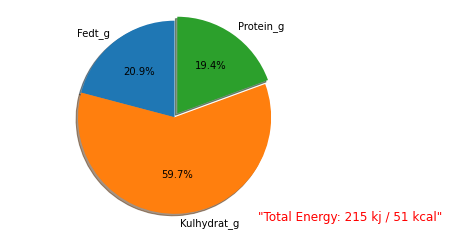

In [37]:
from matplotlib import pyplot as plt

def piechart_fooditem_energy(df_fooditem):
 

  # Pie chart, where the slices will be ordered and plotted counter-clockwise:
  labels = ["Fedt_g", "Kulhydrat_g", "Protein_g"]
  
  sizes =  df_fooditem.loc[:, ["Protein_deklaration_g", 'Kulhydrat_deklaration_g', 'Fedt_total_g']].values.tolist()[0] # 3rd to 8th column value from indivisual-item 
  #sizes= [i*0 for i in sizes if i < 0 ]
  explode = (0, 0, 0.05)  # only "explode" the 3rd slice (i.e. 'Protein')

  fig, ax = plt.subplots()
  ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
  ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        #plt.title(f'"Total Energy in KJ: {df_fooditem.Energy_KJ.values}"', fontsize=12)
  ax.text(1.30, 0.005, f'"Total Energy: {df_fooditem.Energy_kj.item()} kj / {df_fooditem.Energy_kcal.item()} kcal"', fontsize=12, verticalalignment='bottom', horizontalalignment='right', transform=ax.transAxes, color='red')

  #ax.tight_layout()
  #ax.legend()
  #graph=get_graph()
  #return graph
piechart_fooditem_energy(dfn)

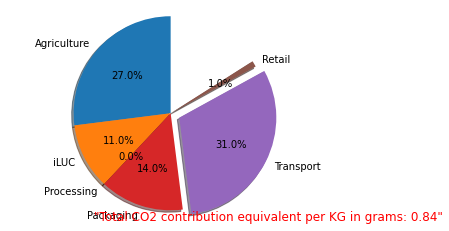

In [43]:
def piechart_fooditem_co2(df_fooditem):
        #self.df_fooditem=df_fooditem
        

        # Pie chart, where the slices will be ordered and plotted counter-clockwise:
        labels = ['Agriculture', 'iLUC', 'Processing', 'Packaging', 'Transport', 'Retail']
        sizes =  df_fooditem[labels].values.tolist()[0] # 3rd to 8th column value from indivisual-item 
        sizes = [0 if i < 0 else i for i in sizes] # Negetive value replace with 0

        explode = (0, 0, 0, 0, 0.1, 0)  # only "explode" the 5th slice (i.e. 'Transport')

        fig, ax = plt.subplots()
        ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
        ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        #plt.title(f'"Total CO2 contribution equivalent per KG: {df_fooditem.Total_CO2_eq_perkg.values}"', fontsize=12)
        ax.text(1.30, 0.005, f'"Total CO2 contribution equivalent per KG in grams: {df_fooditem.Total_CO2_eq_perkg.item()}"', fontsize=12, verticalalignment='bottom', horizontalalignment='right', transform=ax.transAxes, color='red')
        #plt.tight_layout()
        #graph=get_graph()
        #ax.legend()
        #return graph

df= pd.read_excel(data_climate_selected, sheet_name=0, index_col=0, header=0, skiprows=0)
df
food_name= dfn.FødevareNavn.item()
food_name
df_climate= df[df.Product_dk== food_name]
df_climate
piechart_fooditem_co2(df_climate)

In [267]:
def surface_properties_image(self):
        '''Widgets for canopy properties'''

        self.w_PT_But = widgets.Button(
            description='Browse Initial alphaPT Image')
        self.w_PT = widgets.Text(description=' ', value=str(self.max_PT), width=500)
        self.w_LAD_But = widgets.Button(
            description='Browse Leaf Angle Distribution Image')
        self.w_LAD = widgets.Text(description='(degrees)', value=str(self.x_LAD), width=500)
        self.w_leafwidth_But = widgets.Button(
            description='Browse Leaf Width Image')
        self.w_leafwidth = widgets.Text(description='(m)', value=str(self.leaf_width), width=500)
        self.w_zsoil_But = widgets.Button(
            description='Browse Soil Roughness Image')
        self.w_zsoil = widgets.Text(description='(m)', value=str(self.z0soil), width=500)
        self.w_lc_But = widgets.Button(
            description='Browse Land Cover Image')
        # Landcover classes and values come from IGBP Land Cover Type Classification
        self.w_lc = widgets.Dropdown(
            options={
                'CROP': 12,
                'GRASS': 10,
                'SHRUB': 6,
                'CONIFER': 1,
                'BROADLEAVED': 4},
            value=self.landcover,
            description=" ",
            width=300)
        lcText = widgets.HTML(value='''Land cover information is used to estimate roughness. <BR>
                                    For shrubs, conifers and broadleaves we use the model of <BR>
                                    Schaudt & Dickinson (2000) Agricultural and Forest Meteorology. <BR>
                                    For crops and grasses we use a fixed ratio of canopy height<BR>''', width=600)

        self.calc_row_options()
        self.veg_page = widgets.VBox([widgets.HTML('Select alphaPT image or type a constant value'),
                                      widgets.HBox([self.w_PT_But, self.w_PT]),
                                      widgets.HTML('Select leaf angle distribution image or type a constant value'),
                                      widgets.HBox([self.w_LAD_But, self.w_LAD]),
                                      widgets.HTML('Select leaf width image or type a constant value'),
                                      widgets.HBox([self.w_leafwidth_But, self.w_leafwidth]),
                                      widgets.HTML('Select soil roughness image or type a constant value'),
                                      widgets.HBox([self.w_zsoil_But, self.w_zsoil]),
                                      widgets.HTML('Select landcover image or type a constant value'),
                                      widgets.HBox([self.w_lc_But, self.w_lc]),
                                      lcText,
                                      widgets.HBox([self.w_row, self.w_rowaz])], background_color='#EEE')

        self.w_PT_But.on_click(
            lambda b: self._on_input_clicked(b, 'Initial alphaPT', self.w_PT))
        self.w_LAD_But.on_click(
            lambda b: self._on_input_clicked(b, 'Leaf Angle Distribution', self.w_LAD))
        self.w_leafwidth_But.on_click(
            lambda b: self._on_input_clicked(b, 'Leaf Width', self.w_leafwidth))
        self.w_zsoil_But.on_click(
            lambda b: self._on_input_clicked(b, 'Soil Roughness', self.w_zsoil))
        self.w_lc_But.on_click(
            lambda b: self._input_dropdown_clicked(b, 'Land Cover', self.w_lc)) 
